# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [2]:
### Your code implementation goes here.
### Feel free to use as many code cells as needed.

In [3]:
%matplotlib inline

#### cnn_trainer.py

In [2]:
from __future__ import print_function

import gc
import math

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
from data_loader import MNISTLoader, SVHNLoader

_DEBUG = True

def _log(message, end='\r\n'):
    if _DEBUG:
        print(message, end=end)

class CNNTrainer:

    def __init__(self):

        return

    def weight_variable(self, shape):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.1), dtype=tf.float32)

    def bias_variable(self, shape):
        return tf.Variable(tf.zeros(shape), dtype=tf.float32)

    def conv2d(self, x, W):
        return tf.nn.conv2d(x, W,
                            strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(self, x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], padding='SAME')

    def get_conv2d(name, data, patch, d_in, d_out, stride, pooling=None):
        weights = tf.Variable(tf.truncated_normal([patch, patch, d_in, d_out],
                                                  stddev=get_conv2d_weights_init_stddev(img_w, img_h, d_in)),
                              name=str('%s_w' % name))
        biases = tf.Variable(tf.zeros([d_out]),
                             name=str('%s_b' % name))
        layer = tf.nn.relu(tf.nn.conv2d(data, weights, stride, padding='SAME') + biases)
        if pooling is not None:
            layer = tf.nn.max_pool(layer, pooling, pooling, padding='SAME')
        return weights, biases, layer

    def get_conv2d_weights_init_stddev(w, h, d_in):
        # from https://arxiv.org/pdf/1502.01852v1.pdf
        return math.sqrt(2.0 / (w*h*d_in))

    def get_fc(name, data, depth, relu=True):
        inbound = int(data.get_shape()[1])
        weights = tf.Variable(tf.truncated_normal([inbound, depth], stddev=math.sqrt(2.0 / inbound), name=str('%s_w' % name)))
        biases = tf.Variable(tf.zeros([depth]), name=str('%s_b' % name))
        layer = tf.matmul(data, weights) + biases
        if relu is True:
            layer = tf.nn.relu(layer)
        return weights, biases, layer

In [3]:
class MNISTTrainer(CNNTrainer):
    tf_x = None
    tf_y_ = None

    tf_keep_prob = None
    tf_l2_beta = None

    train_dataset = None
    test_dataset = None

    tf_optimizer = None
    tf_accuracy = None
    tf_loss = None

    raw_image_shape = None
    image_shape = None
    label_shape = None

    is_model_initialized = False

    tf_debug1 = None
    tf_debug2 = None
    tf_debug3 = None
    tf_debug4 = None

    seed = 42

    def __init__(self, image_shape=[None, 32, 32, 3], label_shape=[None, 10]):

        self.image_shape = image_shape
        self.label_shape = label_shape
        self.raw_image_shape = self.image_shape if image_shape[3] != 1 else image_shape[0:3]

        _log('input shape must be ', end='')
        _log(self.raw_image_shape)

        self.tf_x = tf.placeholder(tf.float32, self.raw_image_shape)
        self.tf_y_ = tf.placeholder(tf.float32, self.label_shape)

        self.tf_learning_rate = tf.placeholder(tf.float32)
        self.tf_l2_beta = tf.placeholder(tf.float32)

        self.tf_keep_prob = tf.placeholder(tf.float32)

        return

    def set_model(self):
        self.is_model_initialized = True

        x_input = tf.reshape(self.tf_x, [-1] + self.image_shape[1:4])

        # convolution vector definition
        w_conv1 = self.weight_variable([5, 5, 1, 16])
        b_conv1 = self.bias_variable([16])

        w_conv2 = self.weight_variable([5, 5, 16, 32])
        b_conv2 = self.bias_variable([32])

        w_conv3 = self.weight_variable([5, 5, 32, 64])
        b_conv3 = self.bias_variable([64])

        w_conv4 = self.weight_variable([5, 5, 64, 128])
        b_conv4 = self.bias_variable([128])

        w_fc1 = self.weight_variable([4 * 4 * 128, 256])
        b_fc1 = self.bias_variable([256])

        w_fc2 = self.weight_variable([256, 128])
        b_fc2 = self.bias_variable([128])

        # weight & bias matrix depends on features
        w_fc2_len = self.weight_variable([128, 10])
        b_fc2_len = self.bias_variable([10])

        w_fc2_d1 = self.weight_variable([128, 10])
        b_fc2_d1 = self.bias_variable([10])

        w_fc2_d2 = self.weight_variable([128, 10])
        b_fc2_d2 = self.bias_variable([10])

        w_fc2_d3 = self.weight_variable([128, 10])
        b_fc2_d3 = self.bias_variable([10])

        w_fc2_d4 = self.weight_variable([128, 10])
        b_fc2_d4 = self.bias_variable([10])

        w_fc2_d5 = self.weight_variable([128, 10])
        b_fc2_d5 = self.bias_variable([10])

        w_fc2_d6 = self.weight_variable([128, 10])
        b_fc2_d6 = self.bias_variable([10])

        # convolution layer
        h_conv1 = tf.nn.relu(self.conv2d(x_input, w_conv1) + b_conv1)
        h_pool1 = self.max_pool_2x2(h_conv1)

        h_conv2 = tf.nn.relu(self.conv2d(h_pool1, w_conv2) + b_conv2)
        h_pool2 = self.max_pool_2x2(h_conv2)

        h_conv3 = tf.nn.relu(self.conv2d(h_pool2, w_conv3) + b_conv3)
        h_pool3 = self.max_pool_2x2(h_conv3)

        h_conv4 = tf.nn.relu(self.conv2d(h_pool3, w_conv4) + b_conv4)
        h_pool4 = self.max_pool_2x2(h_conv4)

        # fully connected layer
        shape  = h_pool4.get_shape().as_list()

        h_pool4_flat = tf.reshape(h_pool4, [-1, shape[1] * shape[2] * shape[3]])

        h_pool4_flat_dropout = tf.nn.dropout(h_pool4_flat, self.tf_keep_prob, seed=self.seed)
        h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat_dropout, w_fc1) + b_fc1)

        # dropout
        h_fc1_dropout = tf.nn.dropout(h_fc1, self.tf_keep_prob, seed=self.seed)
        h_fc2 = tf.nn.relu(tf.matmul(h_fc1_dropout, w_fc2)+b_fc2)

        # readout layer
        pred_r_len = tf.matmul(h_fc2, w_fc2_len) + b_fc2_len
        pred_len = tf.reshape(pred_r_len, [-1,10])

        pred_r_d1 = tf.matmul(h_fc2, w_fc2_d1) + b_fc2_d1
        pred_d1 = tf.reshape(pred_r_d1, [-1,10])

        pred_r_d2 = tf.matmul(h_fc2, w_fc2_d2) + b_fc2_d2
        pred_d2 = tf.reshape(pred_r_d2, [-1,10])

        pred_r_d3 = tf.matmul(h_fc2, w_fc2_d3) + b_fc2_d3
        pred_d3 = tf.reshape(pred_r_d3, [-1,10])

        pred_r_d4 = tf.matmul(h_fc2, w_fc2_d4) + b_fc2_d4
        pred_d4 = tf.reshape(pred_r_d4, [-1,10])

        pred_r_d5 = tf.matmul(h_fc2, w_fc2_d5) + b_fc2_d5
        pred_d5 = tf.reshape(pred_r_d5, [-1,10])

        pred_r_d6 = tf.matmul(h_fc2, w_fc2_d6) + b_fc2_d6
        pred_d6 = tf.reshape(pred_r_d6, [-1,10])

        # loss calculation
        softmax_len = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,0,:],
                                                              logits=pred_len)
        softmax_d1 = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,1,:],
                                                              logits=pred_d1)
        softmax_d2 = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,2,:],
                                                              logits=pred_d2)
        softmax_d3 = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,3,:],
                                                              logits=pred_d3)
        softmax_d4 = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,4,:],
                                                              logits=pred_d4)
        softmax_d5 = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,5,:],
                                                              logits=pred_d5) 
        softmax_d6 = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,6,:],
                                                              logits=pred_d6)

        regularization = tf.nn.l2_loss(w_fc1) + tf.nn.l2_loss(b_fc1)
        self.tf_loss = self.tf_l2_beta * regularization

        self.tf_loss += tf.reduce_mean(softmax_len)
        self.tf_loss += tf.reduce_mean(softmax_d1)
        self.tf_loss += tf.reduce_mean(softmax_d2)
        self.tf_loss += tf.reduce_mean(softmax_d3)
        self.tf_loss += tf.reduce_mean(softmax_d4)
        self.tf_loss += tf.reduce_mean(softmax_d5)
        # self.tf_loss += tf.reduce_mean(softmax_d6)

        # loss optimizer 
        self.tf_optimizer = tf.train.AdamOptimizer(learning_rate=self.tf_learning_rate).minimize(self.tf_loss)

        # accuracy calculation
        pred_combined = tf.stack([pred_len, pred_d1, pred_d2, pred_d3, pred_d4, pred_d5, pred_d6], axis=1)
        predict = tf.reshape(pred_combined, (-1, 70))

        print(predict)
        print(self.tf_y_)

        is_correct_pred = tf.equal(
            tf.argmax(predict, 1), tf.argmax(self.tf_y_, 1))
        self.tf_accuracy = tf.reduce_mean(tf.cast(is_correct_pred, tf.float32))

        self.tf_debug1 = predict
        self.tf_debug2 = self.tf_y_
        self.tf_debug3 = tf.argmax(predict, 1)
        self.tf_debug4 = tf.argmax(self.tf_y_, 1)


    def train(self):
        if not self.is_model_initialized:
            raise AssertionError('you must initilize model using set_model function')

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            shuffle_step = 0

            _log('we\'re about to training using %d trainset...' % self.train_dataset[0].shape[0])

            # Batching data
            batch_size = 50
            train_size = self.train_dataset[0].shape[0]

            _log('trainset size : {:4d}'.format(train_size))
            _log('batch    size : {:4d}'.format(batch_size))

            _log('. : 1 training epoch')

            for epoch in range(200):

                # Shuffling the train sets
                indices = np.random.permutation(range(self.train_dataset[0].shape[0]))
                for i, _ in enumerate(self.train_dataset):
                    self.train_dataset[i] = self.train_dataset[i][indices]

                # batch_ training
                for batch_step in range(0, train_size, batch_size):

                    batch = [
                        self.train_dataset[0][batch_step:batch_step+batch_size],
                        self.train_dataset[4][batch_step:batch_step+batch_size],
                        self.train_dataset[1][batch_step:batch_step+batch_size]]

                    # Check batch images for the training
                    if False:
                        fig = plt.figure(figsize=(12, 1), dpi=80)
    
                        for i in range(12):
                            plt.subplot(1, 12, i+1)
                            plt.title(batch[2][i])
                            plt.imshow(batch[0][i,:,:].reshape(64, 64),
                                       interpolation='nearest',
                                       cmap='Grey')
                            plt.tight_layout()

                        plt.show()

                    feed_train ={self.tf_x: batch[0],
                                 self.tf_y_: batch[1],
                                 self.tf_learning_rate: 3.1e-4,
                                 self.tf_l2_beta: 16e-4,
                                 self.tf_keep_prob: 0.5}
    
                    feed_accu ={self.tf_x: batch[0],
                                 self.tf_y_: batch[1],
                                 self.tf_learning_rate: 3.1e-4,
                                 self.tf_l2_beta: 16e-4,
                                 self.tf_keep_prob: 1.0}
    
                    feed_test = {self.tf_x: self.test_dataset[0],
                                 self.tf_y_: self.test_dataset[4],
                                 self.tf_learning_rate: 3.1e-4,
                                 self.tf_l2_beta: 16e-4,
                                 self.tf_keep_prob: 1.}
    
                    # Do training
                    self.tf_optimizer.run(feed_dict=feed_train)

                print(".", end='')

                if not epoch % 20:
                    _loss, _train_accuracy = sess.run([self.tf_loss, self.tf_accuracy],
                                                      feed_dict=feed_accu)

                    print('')
                    print("epoch {:4d} -> loss : {:05.2f} / training_accuracy: {:05.2f}".format(
                        epoch, _loss, _train_accuracy))

            print('testing accuracy {:05.2f}'.format(self.tf_accuracy.eval(feed_dict=feed_test)))
        return

In [4]:
def train_for_mnist_normal():
    dataset = 'mnist'

    loader = MNISTLoader()
    loader.init_data()

    trainer = MNISTTrainer([None, 28, 28, 1], [None, 10])

    _log('data loading...', end='\r\n')

    trainer.train_dataset = list(loader.get_data("training"))
    trainer.test_dataset = list(loader.get_data("testing"))

    # normal label to one hot encoding
    trainer.train_dataset.append(np.array(loader.label_to_onehot(trainer.train_dataset[1])))
    trainer.test_dataset.append(np.array(loader.label_to_onehot(trainer.test_dataset[1])))

    _log('data validation...', end='\r\n')

    # To check image input
    _log('input image data shape : ', end='')
    _log(trainer.train_dataset[0].shape)

    # To check label input
    _log('input label data shape : ', end='')
    _log(trainer.train_dataset[1].shape)

    # if _DEBUG:
    # fig = plt.figure()
    # fig.add_subplot(1, 1, 1)
    # plt.imshow(trainer.train_dataset[0][0,:,:],
    #                 interpolation='nearest',
    #                 cmap='Greys')
    # plt.show()

    _log('training...')
    trainer.set_model()
    trainer.train()

In [5]:
def train_for_mnist_synthetic():
    dataset = 'mnist'

    loader = MNISTLoader()
    loader.init_data()

    trainer = MNISTTrainer([None, 64, 64, 1], [None, 70])

    _log('data loading...', end='\r\n')

    trainer.train_dataset = list(loader.get_mixed_data("training"))
    trainer.test_dataset = list(loader.get_mixed_data("testing"))

    train_L = np.c_[trainer.train_dataset[3]+1, trainer.train_dataset[2]]
    train_L_1hot = np.array([[loader.label_to_onehot(digit)] for digit in train_L.T])
    train_L_1hot = np.transpose(train_L_1hot, (1,2,0,3))
    train_L_1hot = train_L_1hot.reshape((-1, 7 * 10))

    test_L = np.c_[trainer.test_dataset[3]+1, trainer.test_dataset[2]]
    test_L_1hot = np.array([[loader.label_to_onehot(digit)] for digit in test_L.T])
    test_L_1hot = np.transpose(test_L_1hot, (1,2,0,3))
    test_L_1hot = test_L_1hot.reshape((-1, 7 * 10))

    trainer.train_dataset.append(train_L_1hot)
    trainer.test_dataset.append(test_L_1hot)

    _log('data validation...', end='\r\n')

    # To check image input
    _log('input image data shape : ', end='')
    _log(trainer.train_dataset[0].shape)

    # To check label input
    _log('input label data shape : ', end='')
    _log(trainer.train_dataset[1].shape)

    _log('training...')
    trainer.set_model()
    trainer.train()

In [6]:
def main():
    # train_for_mnist_normal()
    train_for_mnist_synthetic()
    # train_for_svhn_synthetic()

if __name__ == '__main__':
    main()

testing accuracy 00.98
....................
epoch  180 -> loss : 02.25 / training_accuracy: 01.00
....................
epoch  160 -> loss : 03.87 / training_accuracy: 00.98
....................
epoch  140 -> loss : 05.55 / training_accuracy: 00.96
....................
epoch  120 -> loss : 07.51 / training_accuracy: 00.64
....................
epoch  100 -> loss : 08.33 / training_accuracy: 00.60
....................
epoch   80 -> loss : 10.05 / training_accuracy: 00.42
....................
epoch   60 -> loss : 10.14 / training_accuracy: 00.22
....................
epoch   40 -> loss : 10.67 / training_accuracy: 00.22
....................
epoch   20 -> loss : 11.93 / training_accuracy: 00.04
....................
epoch    0 -> loss : 47.37 / training_accuracy: 00.10
we're about to training using 5000 trainset...
trainset size : 5000
batch    size :   50
. : 1 training epoch
Tensor("Reshape_37:0", shape=(?, 70), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 70), dtype=float32)
data val


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:**

 The most difficult part of solving this problem was the process of creating a dataset by attaching MNIST images successively.

The first approach to machine learning was as follows. I had to first decide what to do with the label. So, I labeled a total of seven pieces of information, including length information for numbers, five digits for each digit, and one space for the last unimportant digit.

After that I saw the video mentioned on the Udacity notebook before creating a machine learning model. It was a video related to the SVHN problem, mentioning that the problem was a total of eleven layers, and was a video explaining how to label each piece of information.

When I look at the video, I decided to make the model deeper by assuming it was difficult to predict the problem with LeNet (Convolution layer 2, Fully connected layer 2) given by Tensorflow's CovNet example. So I went to Convolution 5, Fully connected 2.

At first, I designed and trained parameters and labels based on the Tensorflow example, but there was a problem that I did not get as accurate as I thought. So I decided to change the approach somewhat.

In the example, there was one type of label information (10 one-hot encodings), but in this case a total of seven pieces of information had to be described, so applying one-hot encoding at one time resulted in too many labels.

At first I did not think this would affect performance, and I thought about how to improve it because it was hard to debug and improve the model.

  To improve on this, I decided to take the softmax of each element (length, 5 digits, blank) and consider the LOSS of this model as the sum of these. And we applied L2 regulator to this loss function so that we can find the optimal point more quickly.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**


Finally, the model I created was the Convolution Neural Network.

The layer uses four Convolution Layers and two Fully Connected Layers.

At each Convolution Layer we did 2x2 Max Pooling and used ReLU as our Activation Function. In the Fully Connected Layer, I tried to Regularize the information by applying Dropout, respectively.

Here, the Loss function is constructed by using a total of 7 softmaxs, one for the number of digits, the number of digits, and a blank space, and tried to reach the optimum value more quickly by configuring the L2 Regularizer.

As an optimizer, we have chosen AdamOptimer to reach the optimal value faster than the existing gradient descent. (AdamOptimier adds an acceleration concept to the GradientDescentOptimier, which means that the vibration is reduced to reach the optimum value more quickly)

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

Using the numerical images provided by MNIST, images were generated according to the random number generated. (See below for results)

At this time, 1000 images were created for each digit length in order to study various digit numbers. Even if the same number appears, the images will not be the same because you made the images randomly selected.

For example, if you create a 1000 number of 1 length digits, the image will be as many as the number of images provided by MNIST.

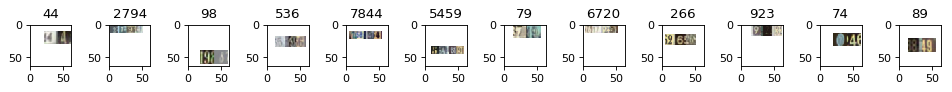

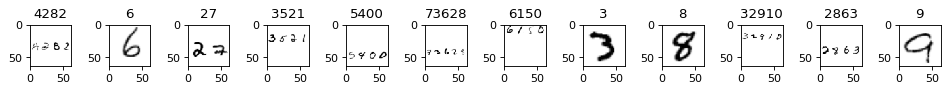

Found and verified train_32x32.mat
Found and verified test_32x32.mat
Found and verified extra_32x32.mat
Found and verified train-images-idx3-ubyte.gz
Found and verified train-labels-idx1-ubyte.gz
Found and verified t10k-images-idx3-ubyte.gz
Found and verified t10k-labels-idx1-ubyte.gz


In [7]:
def main():
    mnist_loader = MNISTLoader()
    svhn_loader = SVHNLoader()

    mnist_loader.download_data()
    svhn_loader.download_data()

    mnist_loader.init_data()
    svhn_loader.init_data()

    mnist_mixed_set = mnist_loader.get_mixed_data()
    svhn_mixed_set = svhn_loader.get_mixed_data()

    mnist_loader.validate_data(mnist_mixed_set[0],
                               mnist_mixed_set[1], 64, 64)
    svhn_loader.validate_data(svhn_mixed_set[0],
                              svhn_mixed_set[1], 64, 64)

if __name__ == '__main__':
    main()

#### data_loader.py

In [8]:
from __future__ import print_function

import gzip
import os
import os.path
import struct
import tarfile
from array import array as pyarray

import numpy as np
import scipy.io as sio
from matplotlib import pyplot as plt
from scipy.misc import imresize

from six.moves import cPickle as pickle
from six.moves import range
from six.moves.urllib.request import urlretrieve

_DEBUG = True


def _log(message):
    if _DEBUG:
        print(message)


class Loader(object):

    pickle_prefix = None
    base_url = None
    dest_folder = None

    image_width = None
    image_height = None
    image_channel = None

    training_data_digits = None
    testing_data_digits = None

    training_data = None
    testing_data = None

    training_mixed_data = None
    testing_mixed_data = None

    @staticmethod
    def maybe_download(base_url, dest_folder, filename, expected_bytes=None):
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        filepath = os.path.join(dest_folder, filename)

        if not os.path.exists(filepath):
            filepath, _ = urlretrieve(base_url + filename, filepath)

        statinfo = os.stat(filepath)

        if expected_bytes is None or statinfo.st_size == expected_bytes:
            print('Found and verified %s' % filename)
        else:
            print(statinfo.st_size)
            raise Exception('Failed to verify ' + filename +
                            '. Can you get to it with a browser ?')
        return filename

    @staticmethod
    def maybe_untargz(filename, dest_folder, force=False):
        extraction_dir = filename.split('.')[0]
        if not os.path.isdir(extraction_dir):
            tar = tarfile.open(filename, 'r:gz')
            tar.extractall(dest_folder)
            tar.close()

            print(filename + " extracted to " + extraction_dir)
        else:
            print("Folder" + extraction_dir + " already exists. Skipping")

    @staticmethod
    def saveAsPickle(images, filename):
        try:
            with open(filename, 'wb') as f:
                pickle.dump(images, f, pickle.HIGHEST_PROTOCOL)
                print(filename + " pickled!")
        except Exception as e:
            print('Unable to save images to ', filename, ':', e)

    @staticmethod
    def loadPickle(file):
        with open(file, 'rb') as pickle_file:
            return pickle.load(pickle_file)

    @staticmethod
    def split_validation(train_data, train_label, split_ratio=0.9):

        permutation_indices = np.random.permutation(train_data.shape[0])
        split_pos = int(train_data.shape[0] * split_ratio)

        train_data_reidx = train_data[permutation_indices]
        valid_dt_set = train_data_reidx[split_pos:]
        train_dt_set = train_data_reidx[:split_pos]

        train_lb_reidx = train_label[permutation_indices]
        valid_lb_set = train_lb_reidx[split_pos:]
        train_lb_set = train_lb_reidx[:split_pos]

        return (train_dt_set, train_lb_set, valid_dt_set, valid_lb_set)

    @staticmethod
    def generate_numbers(max_number, size):
        return np.random.randint(max_number, size=size)

    @staticmethod
    def label_to_onehot(original):
        decimal_kind_of_digit = 10

        count_distinct_value = max(len(np.unique(original)), decimal_kind_of_digit)
        label_1hot = np.zeros((original.shape[0], count_distinct_value))
        label_1hot[np.arange(original.shape[0]), np.transpose(original)] = 1

        return label_1hot

    def init_data(self):
        raise NotImplementedError('Should have implemented this')

    def generate_mixed_digit_data(self,
                                  numbers,
                                  scale=1,
                                  max_length=6,
                                  dims=(64, 64)):
        raise NotImplementedError('Should have implemented this')

    def get_data(self, dataset="training"):
        if not self.training_data_digits or not self.testing_data_digits:
            raise AssertionError('MNIST dataset may be initialized.')

        if dataset == "training":
            return self.training_data
        else:
            return self.testing_data

    def get_digit_data(self, digit, dataset="training"):
        if not self.training_data_digits or not self.testing_data_digits:
            raise AssertionError('MNIST dataset may be initialized.')

        if dataset == "training":
            return self.training_data_digits[digit]
        else:
            return self.testing_data_digits[digit]

    def get_mixed_data(self, dataset="training"):

        if not os.path.exists(self.dest_folder):
            os.makedirs(self.dest_folder)

        if not os.path.exists(
                os.path.join(self.dest_folder,
                             self.pickle_prefix + "_training_mixed_set.pickle")):

            trainset_lbl = list()
            trainset_lbl += Loader.generate_numbers(9, 1000).tolist()
            trainset_lbl += Loader.generate_numbers(99, 1000).tolist()
            trainset_lbl += Loader.generate_numbers(999, 1000).tolist()
            trainset_lbl += Loader.generate_numbers(9999, 1000).tolist()
            trainset_lbl += Loader.generate_numbers(99999, 1000).tolist()

            trainset_lbl = np.array(trainset_lbl)
            trainset_lbl = trainset_lbl[np.random.permutation(trainset_lbl.shape[0])]
            trainset_lbl.reshape(trainset_lbl.shape[0])

            trainset_data = self.generate_mixed_digit_data(trainset_lbl)
            self.training_mixed_data = trainset_data

            Loader.saveAsPickle(self.training_mixed_data,
                                os.path.join(self.dest_folder,
                                             self.pickle_prefix + "_training_mixed_set.pickle"))

        self.training_mixed_data = Loader.loadPickle(os.path.join(self.dest_folder,
                                             self.pickle_prefix + "_training_mixed_set.pickle"))

        if not os.path.exists(
                os.path.join(self.dest_folder,
                             self.pickle_prefix + "_testing_mixed_set.pickle")):

            testset_lbl = list()
            testset_lbl += Loader.generate_numbers(9, 400).tolist()
            testset_lbl += Loader.generate_numbers(99, 400).tolist()
            testset_lbl += Loader.generate_numbers(999, 400).tolist()
            testset_lbl += Loader.generate_numbers(9999, 400).tolist()
            testset_lbl += Loader.generate_numbers(99999, 400).tolist()

            testset_lbl = np.array(testset_lbl)
            testset_lbl = testset_lbl[np.random.permutation(testset_lbl.shape[0])]
            testset_lbl.reshape(testset_lbl.shape[0])

            testset_data = self.generate_mixed_digit_data(testset_lbl)
            self.testing_mixed_data = testset_data

            Loader.saveAsPickle(self.testing_mixed_data,
                                os.path.join(self.dest_folder,
                                             self.pickle_prefix + "_testing_mixed_set.pickle"))

        self.testing_mixed_data = Loader.loadPickle(os.path.join(self.dest_folder,
                                             self.pickle_prefix + "_testing_mixed_set.pickle"))

        if dataset == "training":
            return self.training_mixed_data
        else:
            return self.testing_mixed_data

In [9]:
class SVHNLoader(Loader):

    def __init__(self):

        self.pickle_prefix = 'svhn'
        self.dest_folder = 'SVHN_data/'
        self.base_url = 'http://ufldl.stanford.edu/housenumbers/'

        self.image_width = 32
        self.image_height = 32
        self.image_channel = 3

    def init_data(self):
        if self.training_data_digits or self.testing_data_digits:
            raise AssertionError('svhn dataset may be initialized.')

        if not os.path.exists(
                os.path.join(self.dest_folder, "svhn_training_all.pickle")):
            self.training_data = self.__load_data(dataset="training")
            Loader.saveAsPickle(self.training_data,
                                os.path.join(self.dest_folder,
                                             "svhn_training_all.pickle"))

        if not os.path.exists(
                os.path.join(self.dest_folder, "svhn_testing_all.pickle")):
            self.testing_data = self.__load_data(dataset="testing")
            Loader.saveAsPickle(self.testing_data,
                                os.path.join(self.dest_folder,
                                             "svhn_testing_all.pickle"))

        for i in range(10):
            l = list()
            l.append(i)

            if not os.path.exists(
                    os.path.join(self.dest_folder, "svhn_training_digit_" +
                                 str(i) + ".pickle")):
                d = self.__load_data(dataset="training", digits=l)

                Loader.saveAsPickle(
                    d,
                    os.path.join(self.dest_folder,
                                 "svhn_training_digit_" + str(i) + ".pickle"))

            if not os.path.exists(
                    os.path.join(self.dest_folder, "svhn_testing_digit_" + str(
                        i) + ".pickle")):

                d = self.__load_data(dataset="testing", digits=i)

                Loader.saveAsPickle(
                    d,
                    os.path.join(self.dest_folder,
                                 "svhn_testing_digit_" + str(i) + ".pickle"))

        self.training_data = Loader.loadPickle(
                os.path.join(self.dest_folder,
                             "svhn_training_all.pickle"))

        self.testing_data = Loader.loadPickle(
            os.path.join(self.dest_folder,
                         "svhn_testing_all.pickle"))

        self.training_data_digits = [
            Loader.loadPickle(
                os.path.join(self.dest_folder, "svhn_training_digit_" + str(i)
                             + ".pickle")) for i in range(10)
        ]

        self.testing_data_digits = [
            Loader.loadPickle(
                os.path.join(self.dest_folder, "svhn_testing_digit_" + str(i) +
                             ".pickle")) for i in range(10)
        ]

    def download_data(self):
        svhn_train_images = Loader.maybe_download(
            self.base_url, self.dest_folder, 'train_32x32.mat', 182040794)
        svhn_test_images = Loader.maybe_download(
            self.base_url, self.dest_folder, 'test_32x32.mat', 64275384)
        svhn_extra_images = Loader.maybe_download(
            self.base_url, self.dest_folder, 'extra_32x32.mat', 1329278602)

    def __load_data(self, dataset='training', digits=None):
        files = {'training': 'train_32x32.mat', 'testing': 'test_32x32.mat'}

        try:
            data_fname = os.path.join(self.dest_folder, files[dataset])
        except KeyError:
            raise ValueError("Data set must be 'testing' or 'training'")

        loaded_dict = sio.loadmat(data_fname)
        X = loaded_dict['X']

        # change the matrix's shape
        X_ret = []
        for i in range(X.shape[3]):
            X_ret.append(X[:, :, :, i])
        X_ret = (np.asarray(X_ret).astype(float)) / 255.
 
        # because the value of 10 has been represented '10',
        # we would make it translated into '0'
        y_ret = loaded_dict['y']

        for i in range(len(y_ret)):
            if not y_ret[i] % 10:
                y_ret[i] = 0

        # I'll use numpy advanced indexing for one-hot encoding implementation
        y_ret_1hot = self.label_to_onehot(y_ret)

        indices = []
        if digits is not None:
            indices = np.where(
                y_ret == digits)[0]  # y_ret matrix was n by 1 matrix
        else:
            indices = range(y_ret.shape[0])

        _log("%d of digit %s was selected : " % (len(indices), digits))

        ret = (X_ret[indices, :, :, :], )
        ret += (y_ret[indices], )
        ret += (y_ret_1hot[indices, :], )

        return ret

    def validate_data(self, images, labels, height=None, width=None):
        """
        Prints digits as image along with their labels
        """

        valid_size = min(images.shape[0], 12)
        height = self.image_height if not height else height
        width = self.image_width if not width else width

        if _DEBUG:
            img_data = images
            img_labels = labels

            indices = np.random.randint(img_data.shape[0] - 1, size=valid_size)
            fig = plt.figure(figsize=(12, 3), dpi=80)

            for i, idx in enumerate(indices):
                plt.subplot(1, valid_size, i + 1)
                plt.title(img_labels[idx])
                plt.imshow(img_data[idx], interpolation='nearest')
                plt.tight_layout()

            plt.show()

    def __get_digit_data_rand(self, digit, dataset="training"):
        if not self.training_data_digits or not self.testing_data_digits:
            raise AssertionError('SVHN dataset may be initialized.')

        if dataset == "training":
            return self.training_data_digits[digit][0][np.random.randint(
                self.training_data_digits[digit][0].shape[0])]
        else:
            return self.testing_data_digits[digit][0][np.random.randint(
                self.testing_data_digits[digit][0].shape[0])]

    def generate_mixed_digit_data(self,
                                  numbers,
                                  scale=1,
                                  max_length=6,
                                  dims=(64, 64)):

        images = np.ones([len(numbers), dims[0], dims[1], self.image_channel])
        values = np.zeros(len(numbers)).astype(int)
        lengths = np.zeros([
            len(numbers),
        ]).astype(int)
        digits = np.zeros([len(numbers), 6]).astype(int)

        for i, number in enumerate(numbers):
            values[i] = int(number)

            # To store numbers list into digits list
            # if number is [123, 456], it will store [[1,2,3], [4,5,6]]
            num_digits = [int(j) for j in list(str(values[i]))]
            lengths[i] = min(len(num_digits), 6)
            digits[i, 0:lengths[i]] = num_digits[:lengths[i]]

            # generate mixed images. it will just paste images to righthand direction
            num_images = np.zeros([
                self.image_height, self.image_width * len(num_digits),
                self.image_channel
            ])
            for j, digit in enumerate(num_digits):

                v = self.__get_digit_data_rand(digit)
                num_images[0:self.image_height, j * self.image_width:(
                    j + 1) * self.image_width, 0:self.
                           image_channel] = self.__get_digit_data_rand(digit)

            # make pasted images to 64x64 matrix
            scale = float(dims[0]) / (self.image_width * (lengths[i] + 1))
            if scale != 1:
                num_images = imresize(num_images, scale, interp='bilinear')

            # make image list
            max_top = dims[0] - num_images.shape[0]
            max_left = dims[1] - num_images.shape[1]

            top = np.random.randint(0, max_top) if max_top > 0 else 0
            left = np.random.randint(0, max_left) if max_left > 0 else 0

            images[i, top:top + num_images.shape[0], left:left +
                   num_images.shape[1], 0:self.image_channel] = num_images

        return (images, values, digits, lengths)

In [10]:
class MNISTLoader(Loader):

    training_data_digits = None
    testing_data_digits = None

    training_data = None
    testing_data = None

    def __init__(self):

        self.pickle_prefix = 'mnist'
        self.dest_folder = 'MNIST_data/'
        self.base_url = 'http://yann.lecun.com/exdb/mnist/'

        self.image_width = 28
        self.image_height = 28
        self.image_channel = 1

    def download_data(self):
        mnist_train_images = Loader.maybe_download(
            self.base_url, self.dest_folder, 'train-images-idx3-ubyte.gz',
            9912422)
        mnist_train_labels = Loader.maybe_download(
            self.base_url, self.dest_folder, 'train-labels-idx1-ubyte.gz',
            28881)
        mnist_test_images = Loader.maybe_download(
            self.base_url, self.dest_folder, 't10k-images-idx3-ubyte.gz',
            1648877)
        mnist_test_labels = Loader.maybe_download(
            self.base_url, self.dest_folder, 't10k-labels-idx1-ubyte.gz', 4542)

        files = [mnist_train_images, mnist_train_labels]

        for file in files:
            filepath = os.path.join(self.dest_folder, file)
            inF = gzip.open(filepath, 'rb')
            outF = open(filepath.split(".", 2)[0], 'wb')
            outF.write(inF.read())
            inF.close()
            outF.close()

    def init_data(self):
        if self.training_data_digits or self.testing_data_digits:
            raise AssertionError('MNIST dataset may be initialized.')

        if not os.path.exists(
                os.path.join(self.dest_folder, "mnist_training_all.pickle")):
            self.training_data = self.__load_data(dataset="training", path=self.dest_folder)
            Loader.saveAsPickle(self.training_data,
                                os.path.join(self.dest_folder,
                                             "mnist_training_all.pickle"))

        if not os.path.exists(
                os.path.join(self.dest_folder, "mnist_testing_all.pickle")):
            self.testing_data = self.__load_data(dataset="testing", path=self.dest_folder)
            Loader.saveAsPickle(self.testing_data,
                                os.path.join(self.dest_folder,
                                             "mnist_testing_all.pickle"))

        for i in range(10):
            l = list()
            l.append(i)

            if not os.path.exists(
                    os.path.join(self.dest_folder, "mnist_training_digit_" +
                                 str(i) + ".pickle")):
                d = self.__load_data(
                    dataset="training",
                    digits=l,
                    path=self.dest_folder,
                    asbytes=False,
                    selection=None,
                    return_labels=True,
                    return_indices=False)

                Loader.saveAsPickle(
                    d,
                    os.path.join(self.dest_folder,
                                 "mnist_training_digit_" + str(i) + ".pickle"))

            if not os.path.exists(
                    os.path.join(self.dest_folder, "mnist_testing_digit_" +
                                 str(i) + ".pickle")):

                d = self.__load_data(
                    dataset="testing",
                    digits=l,
                    path=self.dest_folder,
                    asbytes=False,
                    selection=None,
                    return_labels=True,
                    return_indices=False)

                Loader.saveAsPickle(
                    d,
                    os.path.join(self.dest_folder,
                                 "mnist_testing_digit_" + str(i) + ".pickle"))

        self.training_data = Loader.loadPickle(
                os.path.join(self.dest_folder,
                             "mnist_training_all.pickle"))

        self.testing_data = Loader.loadPickle(
            os.path.join(self.dest_folder,
                         "mnist_testing_all.pickle"))

        self.training_data_digits = [
            Loader.loadPickle(
                os.path.join(self.dest_folder, "mnist_training_digit_" + str(i)
                             + ".pickle")) for i in range(10)
        ]

        self.testing_data_digits = [
            Loader.loadPickle(
                os.path.join(self.dest_folder, "mnist_testing_digit_" + str(i)
                             + ".pickle")) for i in range(10)
        ]


    def __load_data(self,
                    dataset="training",
                    digits=None,
                    path="",
                    asbytes=False,
                    selection=None,
                    return_labels=True,
                    return_indices=False):
        """
        from: https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py
        Loads MNIST files into a 3D numpy array.

        Parameters
        ----------
        dataset : str
            Either "training" or "testing", depending on which dataset you want to
            load.
        digits : list
            Integer list of digits to load. The entire database is loaded if set to
            ``None``. Default is ``None``.
        path : str
            Path to your MNIST datafiles. The default is ``None``, which will try
            to take the path from your environment variable ``MNIST``. The images can
            be downloaded from http://yann.lecun.com/exdb/mnist/.
        asbytes : bool
            If True, returns images as ``numpy.uint8`` in [0, 255] as opposed to
            ``numpy.float64`` in [0.0, 1.0].
        selection : slice
            Using a `slice` object, specify what subset of the dataset to load. An
            example is ``slice(0, 20, 2)``, which would load every other digit
            until--but not including--the twentieth.
        return_labels : bool
            Specify whether or not labels should be returned. This is also a speed
            performance if digits are not specified, since then the labels file
            does not need to be read at all.
        return_indicies : bool
            Specify whether or not to return the MNIST indices that were fetched.
            This is valuable only if digits is specified, because in that case it
            can be valuable to know how far
            in the database it reached.

        Returns
        -------
        images : ndarray
            Image images of shape ``(N, rows, cols)``, where ``N`` is the numbers of images. If neither labels nor inices are returned, then this is returned directly, and not inside a 1-sized tuple.
        labels : ndarray
            Array of size ``N`` describing the labels. Returned only if ``return_labels`` is `True`, which is default.
        indices : ndarray
            The indices in the database that were returned.
        """

        # The files are assumed to have these names and should be found in
        # 'path'
        files = {
            'training': ('train-images-idx3-ubyte', 'train-labels-idx1-ubyte'),
            'testing': ('t10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte'),
        }

        try:
            images_fname = os.path.join(path, files[dataset][0])
            labels_fname = os.path.join(path, files[dataset][1])
        except KeyError:
            raise ValueError("Data set must be 'testing' or 'training'")

        # We can skip the labels file only if digits aren't specified and
        # labels aren't asked for
        if return_labels or digits is not None:
            flbl = open(labels_fname, 'rb')
            magic_nr, size = struct.unpack(">II", flbl.read(8))
            labels_raw = pyarray("b", flbl.read())
            flbl.close()

        fimg = open(images_fname, 'rb')
        magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
        images_raw = pyarray("B", fimg.read())
        fimg.close()

        if digits:
            indices = [k for k in range(size) if labels_raw[k] in digits]
        else:
            indices = range(size)

        if selection:
            indices = indices[selection]
        N = len(indices)

        images = np.zeros((N, rows, cols), dtype=np.uint8)

        if return_labels:
            labels = np.zeros((N), dtype=np.int8)
        for i, index in enumerate(indices):
            images[i] = np.array(images_raw[indices[i] * rows * cols:(indices[
                i] + 1) * rows * cols]).reshape((rows, cols))
            if return_labels:
                labels[i] = labels_raw[indices[i]]

        if not asbytes:
            images = images.astype(float) / 255.

        ret = (images, )
        if return_labels:
            ret += (labels, )
        if return_indices:
            ret += (indices, )
        if len(ret) == 1:
            return ret[0]  # Don't return a tuple of one
        else:
            return ret

    def validate_data(self, images, labels, height=None, width=None):
        """
        Prints digits as image along with their labels
        """

        valid_size = min(images.shape[0], 12)
        height = self.image_height if not height else height
        width = self.image_width if not width else width

        if _DEBUG:
            img_data = (images * 255).astype(int)
            img_labels = labels

            indices = np.random.randint(
                img_data.shape[0] - 1,
                size=valid_size) if valid_size > 12 else range(valid_size)
            fig = plt.figure(figsize=(12, 3), dpi=80)

            for i, idx in enumerate(indices):
                plt.subplot(1, valid_size, i + 1)
                plt.title(img_labels[idx])
                plt.imshow(
                    img_data[idx].reshape(height, width),
                    interpolation='nearest',
                    cmap='Greys')
                plt.tight_layout()

            plt.show()

    def __get_digit_data_rand(self, digit, dataset="training"):
        if not self.training_data_digits or not self.testing_data_digits:
            raise AssertionError('MNIST dataset may be initialized.')

        if dataset == "training":
            return self.training_data_digits[digit][0][np.random.randint(
                self.training_data_digits[digit][0].shape[0])].reshape(
                    self.image_height, self.image_width)
        else:
            return self.testing_data_digits[digit][0][np.random.randint(
                self.testing_data_digits[digit][0].shape[0])].reshape(
                    self.image_height, self.image_width)

    def generate_mixed_digit_data(self,
                                  numbers,
                                  scale=1,
                                  max_length=6,
                                  dims=(64, 64)):

        images = np.zeros([len(numbers), dims[0], dims[1]])
        values = np.zeros(len(numbers)).astype(int)
        lengths = np.zeros([
            len(numbers),
        ]).astype(int)
        digits = np.zeros([len(numbers), 6]).astype(int)

        for i, number in enumerate(numbers):
            _log('generate %d\'s image...' % number)
            values[i] = int(number)

            # To store numbers list into digits list
            # if number is [123, 456], it will store [[1,2,3], [4,5,6]]
            num_digits = [int(j) for j in list(str(values[i]))]
            lengths[i] = min(len(num_digits), 6)
            digits[i, 0:lengths[i]] = num_digits[:lengths[i]]

            lengths[i] -= 1

            # generate mixed images. it will just paste images to righthand direction
            num_images = np.zeros(
                [self.image_height, self.image_width * len(num_digits)])
            for j, digit in enumerate(num_digits):

                v = self.__get_digit_data_rand(digit)
                num_images[0:self.image_height, j * self.image_width:(j + 1) *
                           self.image_width] = self.__get_digit_data_rand(
                               digit)

            # make pasted images to 64x64 matrix
            scale = float(dims[0]) / (self.image_width * (lengths[i] + 1))
            if scale != 1:
                num_images = imresize(num_images, scale, interp='bilinear')

            # make image list
            max_top = dims[0] - num_images.shape[0]
            max_left = dims[1] - num_images.shape[1]

            top = np.random.randint(0, max_top) if max_top > 0 else 0
            left = np.random.randint(0, max_left) if max_left > 0 else 0

            images[i, top:top + num_images.shape[0], left:left +
                   num_images.shape[1]] = num_images

        return (images, values, digits, lengths)

train_dt size : 5330
train_lb size : 5330
valid_dt size : 593
valid_lb size : 593
train_dt size : 5330
train_lb size : 5330
valid_dt size : 593
valid_lb size : 593
train_dt size : 5330
train_lb size : 5330
valid_dt size : 593
valid_lb size : 593
train_dt size : 5330
train_lb size : 5330
valid_dt size : 593
valid_lb size : 593
train_dt size : 5330
train_lb size : 5330
valid_dt size : 593
valid_lb size : 593
train_dt size : 5330
train_lb size : 5330
valid_dt size : 593
valid_lb size : 593
train_dt size : 5330
train_lb size : 5330
valid_dt size : 593
valid_lb size : 593
train_dt size : 5330
train_lb size : 5330
valid_dt size : 593
valid_lb size : 593
train_dt size : 5330
train_lb size : 5330
valid_dt size : 593
valid_lb size : 593
train_dt size : 5330
train_lb size : 5330
valid_dt size : 593
valid_lb size : 593


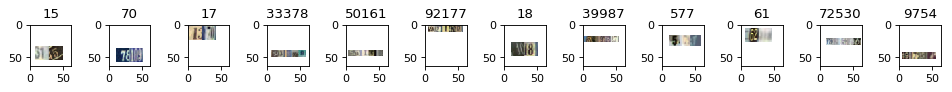

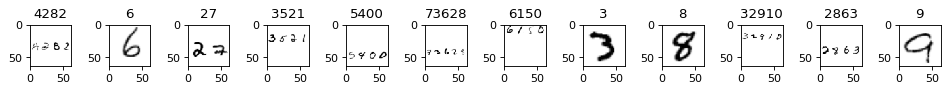

Found and verified train_32x32.mat
Found and verified test_32x32.mat
Found and verified extra_32x32.mat
Found and verified train-images-idx3-ubyte.gz
Found and verified train-labels-idx1-ubyte.gz
Found and verified t10k-images-idx3-ubyte.gz
Found and verified t10k-labels-idx1-ubyte.gz


In [11]:
def main():
    mnist_loader = MNISTLoader()
    svhn_loader = SVHNLoader()

    mnist_loader.download_data()
    svhn_loader.download_data()

    mnist_loader.init_data()
    svhn_loader.init_data()

    # print(
    #     mnist_loader.label_to_onehot(
    #         np.array([0, 1, 2, 3, 4, 5]).reshape(6, 1)))

    dl1 = mnist_loader.get_digit_data(0, "training")
    # mnist_loader.validate_data(dl1[0], dl1[1])

    dt1 = mnist_loader.get_digit_data(0, "testing")
    # mnist_loader.validate_data(dt1[0], dt1[1])

    dl2 = svhn_loader.get_digit_data(1, "training")
    # svhn_loader.validate_data(dl2[0], dl2[1])

    dt2 = svhn_loader.get_digit_data(1, "testing")
    # svhn_loader.validate_data(dt2[0], dt2[1])

    mnist_mixed_set = mnist_loader.get_mixed_data()
    svhn_mixed_set = svhn_loader.get_mixed_data()

    mnist_loader.validate_data(mnist_mixed_set[0],
                               mnist_mixed_set[1], 64, 64)
    svhn_loader.validate_data(svhn_mixed_set[0],
                              svhn_mixed_set[1], 64, 64)

    # cross validation testcase
    for i in range(0, 10):
        da = Loader.loadPickle(
            os.path.join(mnist_loader.dest_folder, "mnist_training_digit_" +
                         str(i) + ".pickle"))
        # mnist_loader.validate_data(da)

        train_dt, train_lb, valid_dt, valid_lb = Loader.split_validation(
            dl1[0], dl1[1])

        print('train_dt size : %d' % train_dt.shape[0])
        print('train_lb size : %d' % train_lb.shape[0])
        print('valid_dt size : %d' % valid_dt.shape[0])
        print('valid_lb size : %d' % valid_lb.shape[0])

if __name__ == '__main__':
    main()

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [12]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



In [4]:
class CNNTrainer:

    def __init__(self):

        return

    def weight_variable(self, shape):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.1), dtype=tf.float32)

    def bias_variable(self, shape):
        return tf.Variable(tf.zeros(shape), dtype=tf.float32)

    def conv2d(self, x, W):
        return tf.nn.conv2d(x, W,
                            strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(self, x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], padding='SAME')

    def get_conv2d(name, data, patch, d_in, d_out, stride, pooling=None):
        weights = tf.Variable(tf.truncated_normal([patch, patch, d_in, d_out],
                                                  stddev=get_conv2d_weights_init_stddev(img_w, img_h, d_in)),
                              name=str('%s_w' % name))
        biases = tf.Variable(tf.zeros([d_out]),
                             name=str('%s_b' % name))
        layer = tf.nn.relu(tf.nn.conv2d(data, weights, stride, padding='SAME') + biases)
        if pooling is not None:
            layer = tf.nn.max_pool(layer, pooling, pooling, padding='SAME')
        return weights, biases, layer

    def get_conv2d_weights_init_stddev(w, h, d_in):
        # from https://arxiv.org/pdf/1502.01852v1.pdf
        return math.sqrt(2.0 / (w*h*d_in))

    def get_fc(name, data, depth, relu=True):
        inbound = int(data.get_shape()[1])
        weights = tf.Variable(tf.truncated_normal([inbound, depth], stddev=math.sqrt(2.0 / inbound), name=str('%s_w' % name)))
        biases = tf.Variable(tf.zeros([depth]), name=str('%s_b' % name))
        layer = tf.matmul(data, weights) + biases
        if relu is True:
            layer = tf.nn.relu(layer)
        return weights, biases, layer


In [10]:
from __future__ import print_function

import gc
import math

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
from data_loader import MNISTLoader, SVHNLoader

_DEBUG = True

def _log(message, end='\r\n'):
    if _DEBUG:
        print(message, end=end)

class SVHNTrainer(CNNTrainer):
    tf_x = None
    tf_y_ = None

    tf_keep_prob = None
    tf_l2_beta = None

    train_dataset = None
    test_dataset = None

    tf_optimizer = None
    tf_accuracy = None
    tf_loss = None

    raw_image_shape = None
    image_shape = None
    label_shape = None

    is_model_initialized = False

    tf_debug1 = None
    tf_debug2 = None
    tf_debug3 = None
    tf_debug4 = None

    seed = 42

    def __init__(self, image_shape=[None, 32, 32, 3], label_shape=[None, 10]):

        self.image_shape = image_shape
        self.label_shape = label_shape
        self.raw_image_shape = self.image_shape if image_shape[3] != 1 else image_shape[0:3]

        _log('input shape must be ', end='')
        _log(self.raw_image_shape)

        self.tf_x = tf.placeholder(tf.float32, self.raw_image_shape)
        self.tf_y_ = tf.placeholder(tf.float32, self.label_shape)

        self.tf_learning_rate = tf.placeholder(tf.float32)
        self.tf_l2_beta = tf.placeholder(tf.float32)

        self.tf_keep_prob = tf.placeholder(tf.float32)

        return

    def set_model(self):
        self.is_model_initialized = True

        x_input = tf.reshape(self.tf_x, [-1] + self.image_shape[1:4])

        # convolution vector definition
        w_conv1 = self.weight_variable([5, 5, 3, 16])
        b_conv1 = self.bias_variable([16])

        w_conv2 = self.weight_variable([5, 5, 16, 32])
        b_conv2 = self.bias_variable([32])

        w_conv3 = self.weight_variable([5, 5, 32, 64])
        b_conv3 = self.bias_variable([64])

        w_conv4 = self.weight_variable([5, 5, 64, 128])
        b_conv4 = self.bias_variable([128])

        w_fc1 = self.weight_variable([4 * 4 * 128, 256])
        b_fc1 = self.bias_variable([256])

        w_fc2 = self.weight_variable([256, 128])
        b_fc2 = self.bias_variable([128])

        # weight & bias matrix depends on features
        w_fc2_len = self.weight_variable([128, 10])
        b_fc2_len = self.bias_variable([10])

        w_fc2_d1 = self.weight_variable([128, 10])
        b_fc2_d1 = self.bias_variable([10])

        w_fc2_d2 = self.weight_variable([128, 10])
        b_fc2_d2 = self.bias_variable([10])

        w_fc2_d3 = self.weight_variable([128, 10])
        b_fc2_d3 = self.bias_variable([10])

        w_fc2_d4 = self.weight_variable([128, 10])
        b_fc2_d4 = self.bias_variable([10])

        w_fc2_d5 = self.weight_variable([128, 10])
        b_fc2_d5 = self.bias_variable([10])

        w_fc2_d6 = self.weight_variable([128, 10])
        b_fc2_d6 = self.bias_variable([10])

        # convolution layer
        h_conv1 = tf.nn.relu(self.conv2d(x_input, w_conv1) + b_conv1)
        h_pool1 = self.max_pool_2x2(h_conv1)

        h_conv2 = tf.nn.relu(self.conv2d(h_pool1, w_conv2) + b_conv2)
        h_pool2 = self.max_pool_2x2(h_conv2)

        h_conv3 = tf.nn.relu(self.conv2d(h_pool2, w_conv3) + b_conv3)
        h_pool3 = self.max_pool_2x2(h_conv3)

        h_conv4 = tf.nn.relu(self.conv2d(h_pool3, w_conv4) + b_conv4)
        h_pool4 = self.max_pool_2x2(h_conv4)

        # fully connected layer
        shape  = h_pool4.get_shape().as_list()

        h_pool4_flat = tf.reshape(h_pool4, [-1, shape[1] * shape[2] * shape[3]])

        h_pool4_flat_dropout = tf.nn.dropout(h_pool4_flat, self.tf_keep_prob, seed=self.seed)
        h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat_dropout, w_fc1) + b_fc1)

        # dropout
        h_fc1_dropout = tf.nn.dropout(h_fc1, self.tf_keep_prob, seed=self.seed)
        h_fc2 = tf.nn.relu(tf.matmul(h_fc1_dropout, w_fc2)+b_fc2)

        # readout layer
        pred_r_len = tf.matmul(h_fc2, w_fc2_len) + b_fc2_len
        pred_len = tf.reshape(pred_r_len, [-1,10])

        pred_r_d1 = tf.matmul(h_fc2, w_fc2_d1) + b_fc2_d1
        pred_d1 = tf.reshape(pred_r_d1, [-1,10])

        pred_r_d2 = tf.matmul(h_fc2, w_fc2_d2) + b_fc2_d2
        pred_d2 = tf.reshape(pred_r_d2, [-1,10])

        pred_r_d3 = tf.matmul(h_fc2, w_fc2_d3) + b_fc2_d3
        pred_d3 = tf.reshape(pred_r_d3, [-1,10])

        pred_r_d4 = tf.matmul(h_fc2, w_fc2_d4) + b_fc2_d4
        pred_d4 = tf.reshape(pred_r_d4, [-1,10])

        pred_r_d5 = tf.matmul(h_fc2, w_fc2_d5) + b_fc2_d5
        pred_d5 = tf.reshape(pred_r_d5, [-1,10])

        pred_r_d6 = tf.matmul(h_fc2, w_fc2_d6) + b_fc2_d6
        pred_d6 = tf.reshape(pred_r_d6, [-1,10])

        # loss calculation
        softmax_len = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,0,:],
                                                              logits=pred_len)
        softmax_d1 = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,1,:],
                                                              logits=pred_d1)
        softmax_d2 = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,2,:],
                                                              logits=pred_d2)
        softmax_d3 = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,3,:],
                                                              logits=pred_d3)
        softmax_d4 = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,4,:],
                                                              logits=pred_d4)
        softmax_d5 = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,5,:],
                                                              logits=pred_d5) 
        softmax_d6 = tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(self.tf_y_, (-1,7,10))[:,6,:],
                                                              logits=pred_d6)

        regularization = tf.nn.l2_loss(w_fc1) + tf.nn.l2_loss(b_fc1)
        self.tf_loss = self.tf_l2_beta * regularization

        self.tf_loss += tf.reduce_mean(softmax_len)
        self.tf_loss += tf.reduce_mean(softmax_d1)
        self.tf_loss += tf.reduce_mean(softmax_d2)
        self.tf_loss += tf.reduce_mean(softmax_d3)
        self.tf_loss += tf.reduce_mean(softmax_d4)
        self.tf_loss += tf.reduce_mean(softmax_d5)
        # self.tf_loss += tf.reduce_mean(softmax_d6)

        # loss optimizer 
        self.tf_optimizer = tf.train.AdamOptimizer(learning_rate=self.tf_learning_rate).minimize(self.tf_loss)

        # accuracy calculation
        pred_combined = tf.stack([pred_len, pred_d1, pred_d2, pred_d3, pred_d4, pred_d5, pred_d6], axis=1)
        predict = tf.reshape(pred_combined, (-1, 70))

        print(predict)
        print(self.tf_y_)

        is_correct_pred = tf.equal(
            tf.argmax(predict, 1), tf.argmax(self.tf_y_, 1))
        self.tf_accuracy = tf.reduce_mean(tf.cast(is_correct_pred, tf.float32))

        self.tf_debug1 = predict
        self.tf_debug2 = self.tf_y_
        self.tf_debug3 = tf.argmax(predict, 1)
        self.tf_debug4 = tf.argmax(self.tf_y_, 1)


    def train(self):
        if not self.is_model_initialized:
            raise AssertionError('you must initilize model using set_model function')

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            shuffle_step = 0

            _log('we\'re about to training using %d trainset...' % self.train_dataset[0].shape[0])

            # Batching data
            batch_size = 50
            train_size = self.train_dataset[0].shape[0]

            _log('trainset size : {:4d}'.format(train_size))
            _log('batch    size : {:4d}'.format(batch_size))

            _log('. : 1 training epoch')

            for epoch in range(400):

                # Shuffling the train sets
                indices = np.random.permutation(range(self.train_dataset[0].shape[0]))
                for i, _ in enumerate(self.train_dataset):
                    self.train_dataset[i] = self.train_dataset[i][indices]

                # batch_ training
                for batch_step in range(0, train_size, batch_size):

                    batch = [
                        self.train_dataset[0][batch_step:batch_step+batch_size],
                        self.train_dataset[4][batch_step:batch_step+batch_size],
                        self.train_dataset[1][batch_step:batch_step+batch_size]]

                    # Check batch images for the training
                    if False:
                        fig = plt.figure(figsize=(12, 1), dpi=80)
    
                        for i in range(12):
                            plt.subplot(1, 12, i+1)
                            plt.title(batch[2][i])
                            plt.imshow(batch[0][i,:,:].reshape(64, 64, 3),
                                       interpolation='nearest')
                            plt.tight_layout()

                        plt.show()

                    feed_train ={self.tf_x: batch[0],
                                 self.tf_y_: batch[1],
                                 self.tf_learning_rate: 3.1e-4,
                                 self.tf_l2_beta: 16e-4,
                                 self.tf_keep_prob: 0.5}
    
                    feed_accu ={self.tf_x: batch[0],
                                 self.tf_y_: batch[1],
                                 self.tf_learning_rate: 3.1e-4,
                                 self.tf_l2_beta: 16e-4,
                                 self.tf_keep_prob: 1.0}
    
                    feed_test = {self.tf_x: self.test_dataset[0],
                                 self.tf_y_: self.test_dataset[4],
                                 self.tf_learning_rate: 3.1e-4,
                                 self.tf_l2_beta: 16e-4,
                                 self.tf_keep_prob: 1.}
    
                    # Do training
                    self.tf_optimizer.run(feed_dict=feed_train)

                print(".", end='')

                if not epoch % 20:
                    _loss, _train_accuracy = sess.run([self.tf_loss, self.tf_accuracy],
                                                      feed_dict=feed_accu)

                    print('')
                    print("epoch {:4d} -> loss : {:05.2f} / training_accuracy: {:05.2f}".format(
                        epoch, _loss, _train_accuracy))

            print('testing accuracy {:05.2f}'.format(self.tf_accuracy.eval(feed_dict=feed_test)))
        return

In [11]:
def train_for_svhn_synthetic():
    dataset = 'svhn'

    # To clean GPU memory
    gc.collect()

    loader = SVHNLoader()
    loader.init_data()

    trainer = SVHNTrainer([None, 64, 64, 3], [None, 70])

    _log('data loading...', end='\r\n')

    trainer.train_dataset = list(loader.get_mixed_data("training"))
    trainer.test_dataset = list(loader.get_mixed_data("testing"))

    train_L = np.c_[trainer.train_dataset[3]+1, trainer.train_dataset[2]]
    train_L_1hot = np.array([[loader.label_to_onehot(digit)] for digit in train_L.T])
    train_L_1hot = np.transpose(train_L_1hot, (1,2,0,3))
    train_L_1hot = train_L_1hot.reshape((-1, 7 * 10))

    test_L = np.c_[trainer.test_dataset[3]+1, trainer.test_dataset[2]]
    test_L_1hot = np.array([[loader.label_to_onehot(digit)] for digit in test_L.T])
    test_L_1hot = np.transpose(test_L_1hot, (1,2,0,3))
    test_L_1hot = test_L_1hot.reshape((-1, 7 * 10))

    trainer.train_dataset.append(train_L_1hot)
    trainer.test_dataset.append(test_L_1hot)

    _log('data validation...', end='\r\n')

    # To check image input
    _log('input image data shape : ', end='')
    _log(trainer.train_dataset[0].shape)

    # To check label input
    _log('input label data shape : ', end='')
    _log(trainer.train_dataset[1].shape)

    _log('training...')
    trainer.set_model()
    trainer.train()

In [12]:
def main():
    # train_for_mnist_normal()
    # train_for_mnist_synthetic()
    train_for_svhn_synthetic()

if __name__ == '__main__':
    main()

.testing accuracy 00.73
...................
epoch  380 -> loss : 01.43 / training_accuracy: 00.82
....................
epoch  360 -> loss : 01.62 / training_accuracy: 00.78
....................
epoch  340 -> loss : 01.46 / training_accuracy: 00.68
....................
epoch  320 -> loss : 01.48 / training_accuracy: 00.64
....................
epoch  300 -> loss : 01.66 / training_accuracy: 00.70
....................
epoch  280 -> loss : 01.80 / training_accuracy: 00.76
....................
epoch  260 -> loss : 03.03 / training_accuracy: 00.74
....................
epoch  240 -> loss : 03.71 / training_accuracy: 00.76
....................
epoch  220 -> loss : 04.54 / training_accuracy: 00.54
....................
epoch  200 -> loss : 06.00 / training_accuracy: 00.38
....................
epoch  180 -> loss : 06.67 / training_accuracy: 00.38
....................
epoch  160 -> loss : 06.71 / training_accuracy: 00.68
....................
epoch  140 -> loss : 09.87 / training_accuracy: 00.18
..

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

The method of creating the data was the one that was processed using the existing MNIST data.

It is a method to randomly select images corresponding to each digit by randomizing 5 digits using random numbers provided by SVHN.

And in this process, the actual data randomly changed the starting position of the image, considering that the position of the number of the image usually changes every time.

The difference from MNIST is that in the case of SVHN, the dataset was a MATLAB file, so it was created using the loadmat function provided by Scipy.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

In the case of SVHN, the performance was better than I thought because it was made by reflecting the solution of the problem that MNIST experienced in solving Q1 ~ Q3.

The difference in SVHN is that data is more complex than MNIST. In fact, what I adjusted at this point was to increase Training Epoch.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

When we used the SVHN model for the first time, the result was about 0.5 times. We increased the number of epochs to about twice the number of times for MNIST, and the prediction rate of the test set increased to about 0.73. Perhaps I think it will be higher if I increase the epoch.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [0]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [0]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [0]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.